# An Implementation of Drop the GAN: In Defense of Patches Nearest Neighbors as Single Image Generative Models (CVPR 2022)

[Link to paper](https://openaccess.thecvf.com/content/CVPR2022/papers/Granot_Drop_the_GAN_In_Defense_of_Patches_Nearest_Neighbors_As_CVPR_2022_paper.pdf)

[Link to Colab](https://colab.research.google.com/drive/1vHPTuevg6NzkzF2c-_jqM1NH_2277eW9?usp=sharing)

Paper Authors: Niv Granot, Ben Feinstein, Assaf Shocher, Shai Bagon, Michal Irani


Code Authors: Alparslan Sertel - sertel.alparslan@metu.edu.tr, Ege Demir - ege.demir@metu.edu.tr

The paper argues against the belief that GANs are superior to classical and rather unsophisticated patch-based methods for image manipulation tasks. The authors express that patch-based methods can be alternated to perform tasks that are considered as “GAN-only”, and even outperform GANs in terms of visual quality and application speed. They propose the adapted patch-patch based method GPNN (Generative Patch Nearest Neighbors) with several modifications 

It is argued that the proposed model is able to generate diverse images from a single neutral image. The model outperforms GANs in terms of the visual quality of the output and the runtime of image generation (from hours to seconds).

**Implementation Notes**

Our model is non-parametric so there is no training/saving the model.

The hyperparameters are not provided in the paper, we had to find them manually. We did not have the time for a complete grid search so these hyperparameters are probably suboptimal.

The details of image resizing were not provided in the article. We used the default resizing method of PIL.

The article uses a Gaussian filter when aggregating patches. We skipped this for now and used the mean of the overlapping pixels for combining them instead for simplicity. We will implement Gaussian filters in v2.

We did not get the results we aimed for because of GPU memory issues. We are hoping to resolve this in v2. We doubt this notebook will run in an environment with <16 GB VRAM. The notebook has been tested in Colab.

—— version 1 submission ——
We did not change our goals.
We could not achieve the goals but we are confident that we will be able to in v2. You can find our qualitative and quantitative results in the notebook. 
The main problem we are facing is GPU VRAM. We are trying to do a very large matrix multiplication which results in OOM. We do not have to load all of the matrix for the multiplication and we are going to implement this for v2.
Once we resolve this we are going to be able to get much higher quality generations. Right now, we have to use very small patch size which we know to lead to bad quality generations. For some cases we are able to get good results, which can be seen in the qualitative results in the notebook. This depends on the nature and resolution of the image.
We have all the necessary infrastructure in place and we will be reducing the memory requirements of our model and finding the optimal hyperparameters. Hyperparameters could also be the problem as they were not given in the paper and we could not do a proper grid search.







# Model

In [1]:
import numpy as np
from PIL import Image
from numpy.lib.stride_tricks import as_strided
import torch

In [2]:
# Divide an image into overlapping PxP patches
def get_image_patches(image, patch_size):

    stride_w = image.strides[0]  # stride of width
    stride_h = image.strides[1]  # stride of height
    stride_c = image.strides[2]  # stride of channel

    width, height, _ = image.shape
    patch_width, patch_height = patch_size, patch_size

    assert width >= patch_width
    assert height >= patch_height

    num_patches_w = width - patch_width + 1
    num_patches_h = height - patch_height + 1

    patches = as_strided(image, shape=(num_patches_w, num_patches_h, patch_width, patch_height, 3),
                         strides=(stride_w, stride_h, stride_w, stride_h, stride_c))

    return patches

In [3]:
# Compute the distance between two images (patches)
def compute_distance_between_images(list1, list2, alpha):

    num_images1, height1, width1, channels1 = list1.shape
    num_images2, height2, width2, channels2 = list2.shape

    mse_values = np.zeros((num_images1, num_images2))

    for i in range(num_images1):
        for j in range(num_images2):
            mse = np.mean((list1[i] - list2[j]) ** 2)
            mse_values[i, j] = mse

    mse_values = mse_values / ((np.min(mse_values, axis=1))[:, np.newaxis] + alpha)

    return mse_values

In [12]:
# Same as above, in Torch
def compute_distance_between_images_pytorch(list1, list2, alpha):

    list1 = torch.from_numpy(list1.astype(np.float16)).to(device)
    list2 = torch.from_numpy(list2.astype(np.float16)).to(device)

    num_images1, height1, width1, channels1 = list1.shape
    num_images2, height2, width2, channels2 = list2.shape

    list1_reshape = list1.view(num_images1, -1)
    list2_reshape = list2.view(num_images2, -1)

    list1_reshape = list1_reshape.unsqueeze(1)
    list2_reshape = list2_reshape.unsqueeze(0)

    # Normalized by 256, else the distance blows up to infinity
    distances = torch.cdist(list1_reshape/256, list2_reshape/256, p=2)

    mse_values = torch.mean(distances.pow(2), dim=1)

    mse_values = mse_values / (torch.min(mse_values, dim=1, keepdim=True).values + alpha)

    mse_values = mse_values.cpu().numpy()

    return mse_values


In [5]:
def aggregate_patches(image, output, P):

    new_image = np.zeros_like(image)
    counter = np.zeros_like(image)

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            new_image[i:i+P, j:j+P] += output[i, j] # Gaussian filter must be used however
                                                    # mean of the pixels is used for v1
            counter[i:i+P, j:j+P] += 1

    new_image = new_image // counter

    return new_image


In [27]:
def pnn(image, Q, K, V, V_shape, alpha, P, C):

    # When using PyTorch we can work much faster so we are able to generate at 
    # higher resolutions (it is a matter of computation time, not memory)
    # but since we are limited by GPU memory we cannot use higher patch sizes
    # > 3 (matter of memory). Using CPU we saw that P=8 seems to be the best 
    # but in this case we cannot get high resolution generations because 
    # generations take a long time

    #distances = compute_distance_between_images_pytorch(Q, K, alpha) # Speed & resolution, GPU
    distances = compute_distance_between_images(Q, K, alpha) # Quality, CPU

    nearest_neighbors = np.argmin(distances, axis=1)
    output = V[nearest_neighbors]
    output = output.reshape(V_shape[0], V_shape[1], P, P, C)
    output = aggregate_patches(image, output, P)
    
    return output

In [31]:
def gpnn(image, N, T, R, alpha, P, C):
    # Pyramid of smaller images, descending in size
    smaller_image_arrs = [np.asarray(image.resize((int(image.size[0]/(i * R)), int(image.size[1]/(i * R)))), dtype=np.uint16) for i in range(1, N+1)]
    smaller_image_arrs.insert(0, np.asarray(image))

    for n in range(N):
        if not n: # T=1 for Nth step
            #Nth step (coarsest scale)
            # Noise is normalized by 64 which is determined empirically
            noise = np.random.normal(size=smaller_image_arrs[-1].shape) * 64
            Q = smaller_image_arrs[-1] + noise # y_n+1
            Q = get_image_patches(Q, P)
            Q = Q.reshape(-1, P, P, C)

            V = smaller_image_arrs[-1] # x_n
            V = get_image_patches(V, P)
            V_shape = V.shape
            V = V.reshape(-1, P, P, C)

            K = smaller_image_arrs[-1] # x_n+1
            K = get_image_patches(K, P)
            K = K.reshape(-1, P, P, C)

            generated = pnn(smaller_image_arrs[-1], Q, K, V, V_shape, alpha, P, C)

        else:
            # Generation from the prev step is resized for the next step
            generated = Image.fromarray(generated.astype(np.uint8)).resize((smaller_image_arrs[-1 * (1 + n)].shape[0], smaller_image_arrs[-1 * (1 + n)].shape[1]))
            generated = np.asarray(generated, dtype=np.uint16)

            # V is the source image at n
            V = smaller_image_arrs[-1 * (1 + n)] # x_n
            V = get_image_patches(V, P)
            V_shape = V.shape
            V = V.reshape(-1, P, P, C)

            # K is the source image at n+1, upscaled (blurry)
            K = Image.fromarray(smaller_image_arrs[-1 * (n)].astype(np.uint8)).resize((smaller_image_arrs[-1 * (1 + n)].shape[0], smaller_image_arrs[-1 * (1 + n)].shape[1]))
            K = np.asarray(K, dtype=np.uint16)
            K = get_image_patches(K, P)
            K = K.reshape(-1, P, P, C)

            # Q is the initial guess, at first from the previous step and
            # then updated at every t as the current guess at step n
            for t in range(T):
                Q = generated
                Q = get_image_patches(Q, P)
                Q = Q.reshape(-1, P, P, C)

                generated = pnn(smaller_image_arrs[-1 * (1 + n)], Q, K, V, V_shape, alpha, P, C)

        #Image.fromarray(generated.astype(np.uint8)).show() # Enable this to show pyramid generations
        torch.cuda.empty_cache()

    return Image.fromarray(generated.astype(np.uint8))




# Hyperparams

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [33]:
# Hyperparameters
# These were not given in the paper except for alpha, and they were selected
# based on good qualitative performance and runtime

P = 8 # Patch size, 8 works the best but 3 is the max P for GPU
R = 2 # Resizing factor
N = 10 # Steps in pyramid, 10 for qualitative
alpha = 5 * 0.001 # Alpha in the distance func denominator
T = 10 # Number of iterations in each level, T = 1 in coarsest level, T=5 for qualitative

# Quantitative Results

In [17]:
!git clone https://github.com/tamarott/SinGAN

fatal: destination path 'SinGAN' already exists and is not an empty directory.


In [18]:
!python -m pip install -qq -r SinGAN/requirements.txt

In [21]:
!mv *.jpg real/

In [ ]:
import glob

path = r'real/*.jpg'
files = glob.glob(path)

for f in files:
  image = Image.open(f)
  C = len(image.getbands())

  generated = gpnn(image, N, T, R, alpha, P, C)
  generated.save('fake/' + f.split('/')[-1])
  

In [25]:
!python SinGAN/SIFID/sifid_score.py --path2real real --path2fake fake 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100% 104M/104M [00:04<00:00, 23.7MB/s]
100% 1/1 [00:00<00:00,  8.39it/s]
100% 1/1 [00:00<00:00, 138.16it/s]
100% 1/1 [00:00<00:00, 72.66it/s]
100% 1/1 [00:00<00:00, 219.38it/s]
100% 1/1 [00:00<00:00, 60.55it/s]
100

SIFID on Places 50

Our Result: **4.184**

Original Result for stdev=0.75: **0.071**

The result is very bad because of VRAM issues leading to small patch size. Once we solve this we will be able to get better generations

# Qualitative Results

In [ ]:
# The generations below are outputs of the model at every step of the generation 
# pyramid at increasing resolutions

In [ ]:
# All qualitative goal generations are below

In [34]:
# The generations below are made using the CPU using P=8 so the generated image 
# makes sense however the resolution is very low because it is slow

image = Image.open('people_on_the_beach.jpg')
C = len(image.getbands())

generated = gpnn(image, N, T, R, alpha, P, C)
generated.show()

KeyboardInterrupt: ignored

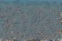

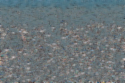

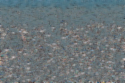

In [ ]:
# The generations below are made using the CPU using P=3 so the generated image 
# makes less sense however the resolution is higher

image = Image.open('people_on_the_beach.jpg')
C = len(image.getbands())

generated = gpnn(image, N, T, R, alpha, P, C)
generated.show()

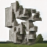

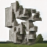

In [ ]:
image = Image.open('6_1.jpg')
C = len(image.getbands())

N = 5

generated = gpnn(image, N, T, R, alpha, P, C)
generated.show()

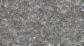

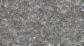

In [ ]:
image = Image.open('6_2.jpg')
C = len(image.getbands())

N = 7

generated = gpnn(image, N, T, R, alpha, P, C)
generated.show()

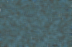

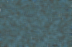

In [ ]:
image = Image.open('5_1.jpg')
C = len(image.getbands())

N = 7

generated = gpnn(image, N, T, R, alpha, P, C)
generated.show()

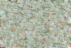

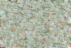

In [ ]:
image = Image.open('5_2.jpg')
C = len(image.getbands())

N = 7

generated = gpnn(image, N, T, R, alpha, P, C)
generated.show()

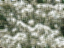

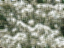

In [ ]:
image = Image.open('5_3.jpg')
C = len(image.getbands())

N = 7

generated = gpnn(image, N, T, R, alpha, P, C)
generated.show()

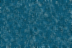

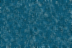

In [ ]:
image = Image.open('5_4.jpg')
C = len(image.getbands())

N = 8

generated = gpnn(image, N, T, R, alpha, P, C)
generated.show()

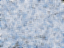

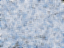

In [ ]:
image = Image.open('5_5.jpg')
C = len(image.getbands())

N = 7

generated = gpnn(image, N, T, R, alpha, P, C)
generated.show()

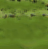

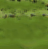

In [ ]:
image = Image.open('5_6.jpg')
C = len(image.getbands())

N = 6

generated = gpnn(image, N, T, R, alpha, P, C)
generated.show()

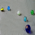

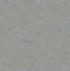

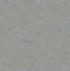

In [ ]:
image = Image.open('4_1.jpg')
C = len(image.getbands())

N = 8

generated = gpnn(image, N, T, R, alpha, P, C)
generated.show()